In [1]:
import os
import argparse
import pandas as pd
import subprocess
import json
import requests
from typing import List
import time
import numpy as np
import pandas as pd
from scipy.stats import kstest,ttest_ind
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams.update({'font.size': 14, 'axes.linewidth': 2, 'xtick.major.width': 1.5, 'xtick.major.size': 7, 'ytick.major.width': 1.5, 'ytick.major.size': 7})
from matplotlib.backends.backend_pdf import PdfPages

"""
Resources:
https://maayanlab.cloud/Enrichr/help#api
https://maayanlab.cloud/Enrichr/#libraries
"""

def get_population_geneset(gene_burden_df, save_dir):
    popgenefile = os.path.join(save_dir, "genes_pop.list")
    with open(popgenefile, "w") as f:
        for g in gene_burden_df.gene.unique():
            f.write(f"{g}\n")
    popgenset = set(gene_burden_df.gene.unique())
    return list(popgenset)


def get_combo_genes(combo_df, save_dir):
    combo_df = combo_df.loc[combo_df.p_value_bmi_prs<0.05]
    genes = set("|".join(combo_df.uniq_items.values).split("|"))
    geneset = set([g.replace("Input_", "", 1) for g in genes])

    genefile = os.path.join(save_dir, "genes.list")
    with open(genefile, "w") as f:
        for g in geneset:
            f.write(f"{g}\n")
    return list(geneset)

def save_enrichr_results(results, save_file):
    os.makedirs(os.path.dirname(save_file), exist_ok=True)
    with open(save_file, "w") as f:
        f.write("Term,p_val,adj_pval,odds_ratio,combined_score,genes\n")
        for lines in results:
            if lines[2]<0.05:
                f.write(f"{lines[1].replace(',', '')},{lines[2]},{lines[6]},{lines[3]},{lines[4]},{'|'.join(lines[5])}\n")
    return

def run_enrichment_helper(study_genes, population_genes, enrich_database, save_file):
    # upload geneset
    base_url = "https://maayanlab.cloud/speedrichr"
    description = f"Rarecomb gene set enrichment in {enrich_database}"
    study_res = requests.post(
        f"{base_url}/api/addList",
        files=dict(list=(None, '\n'.join(study_genes)), description=(None, description))
        )
    if study_res.ok:
        userlist_response = study_res.json()
        userListId=userlist_response["userListId"]
    else:
        raise NotImplementedError(f"{enrich_database} enrichment not completed due to study gene posting failure")

    # upload background
    pop_res = requests.post(
        f"{base_url}/api/addbackground",
        data=dict(background='\n'.join(population_genes))
    )
    if pop_res.ok:
        background_response = pop_res.json()
        backgroundid=background_response["backgroundid"]
    else:
        raise NotImplementedError(f"{enrich_database} enrichment not completed due to pop gene posting failure")

    # run enrichment
    enrich_res = requests.post(
            f"{base_url}/api/backgroundenrich",
            data=dict(
            userListId=userListId,
            backgroundid=backgroundid,
            backgroundType=enrich_database,
            )
        )
    if enrich_res.ok:
        try:
            results = json.loads(enrich_res.text)[enrich_database]
            save_enrichr_results(results, save_file)
        except:
            print(f"Results could not be decoded for {enrich_database}")
    else:
        raise NotImplementedError(f"{enrich_database} enrichment not completed due to run enrichment failure")
    return

def save_pdf(save_file, fig):
    pdf = PdfPages(save_file)
    pdf.savefig(fig, bbox_inches='tight', dpi=300)
    pdf.close()
    return

def create_dot_plot(go_file, terms_col="Term", odds_ratio_col="odds_ratio", gene_col="genes", gene_pval_col="adj_pval", ncat=20, figsize=(5,7)):
    # read and parse go file
    go_df = pd.read_csv(go_file)
    go_df[terms_col] = go_df[terms_col].apply(lambda x: x[0].upper() + x[1:])
    go_df["gene_counts"] = go_df[gene_col].apply(lambda x: len(x.split("|")))
    plot_df = go_df.sort_values(gene_pval_col).head(ncat)
    
    plot_df = plot_df.sort_values(odds_ratio_col, ascending=False)
    fig, axes = plt.subplots(figsize=figsize)
    norm = plt.Normalize(0, 0.05) # plot_df['qvalue'].min(), plot_df['qvalue'].max()
    sns_ax = sns.scatterplot(
        data=plot_df, x=odds_ratio_col, y=terms_col, 
        size="gene_counts", hue=gene_pval_col, ax=axes, sizes=(100, 300), palette='RdBu', hue_norm=norm, linewidth=0.5, edgecolor="k"
        )
    sns_ax.legend(loc='center left', bbox_to_anchor=(1.5, 0.5), ncol=1)
    sns_ax.set_xlabel("Gene ratio")
    sns_ax.set_ylabel("")
    sns_ax.set_axisbelow(True)
    sns_ax.yaxis.grid(ls="--", which="major")
    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
    sm.set_array([])
    sns_ax.figure.colorbar(sm, ax=axes, shrink=0.25, aspect=5, ticks=[0, 0.01, 0.05])
    # axes.margins(x=0.1, y=0.1)
    return fig, axes

def run_enrichment(study_genes, population_genes, save_dir, enrich_database=["Allen_Brain_Atlas_10x_scRNA_2021", "dbGaP", "GO_Biological_Process_2023", "GTEx_Tissues_V8_2023", "GWAS_Catalog_2023", "Human_Phenotype_Ontology", "KEGG_2021_Human", "MGI_Mammalian_Phenotype_Level_4_2021", "OMIM_Disease"]):
    for ed in enrich_database:
        print(ed)
        enrich_file = os.path.join(save_dir, f"{ed}_enrich.csv")
        run_enrichment_helper(study_genes, population_genes, ed, enrich_file)
        fig, ax = create_dot_plot(enrich_file, ncat=20)
        ax.set_title(f"{ed}")
        fig_save_dir = os.path.join(save_dir, "figures")
        os.makedirs(fig_save_dir, exist_ok=True)
        fig_save_file = os.path.join(fig_save_dir, f"{ed}.pdf")
        save_pdf(fig_save_file, fig)
        time.sleep(30)
    return


In [2]:
combo_files = [
    "/data6/deepro/ukb_bmi/3_characterization/data/pilot/combo_top_prs_decile_enrich.csv",
    "/data6/deepro/ukb_bmi/3_characterization/data/pilot/combo_bottom_prs_decile_enrich.csv"
]

save_dir = [
    "/data6/deepro/ukb_bmi/3_characterization/data/pilot/combo_top_prs_enrich/",
    "/data6/deepro/ukb_bmi/3_characterization/data/pilot/combo_bottom_prs_enrich"
]

gene_burden_file = "/data6/deepro/ukb_bmi/0_data_preparation_and_download/exome_annot/data/processed_burden/all_gene_burden.csv.gz"


Allen_Brain_Atlas_10x_scRNA_2021
dbGaP
GO_Biological_Process_2023
GTEx_Tissues_V8_2023
GWAS_Catalog_2023
Human_Phenotype_Ontology
KEGG_2021_Human
MGI_Mammalian_Phenotype_Level_4_2021
OMIM_Disease
Allen_Brain_Atlas_10x_scRNA_2021
dbGaP
GO_Biological_Process_2023
GTEx_Tissues_V8_2023
GWAS_Catalog_2023
Human_Phenotype_Ontology
KEGG_2021_Human
MGI_Mammalian_Phenotype_Level_4_2021
OMIM_Disease


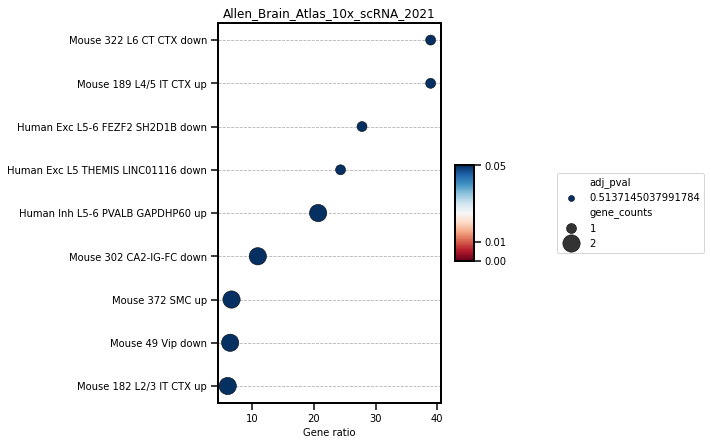

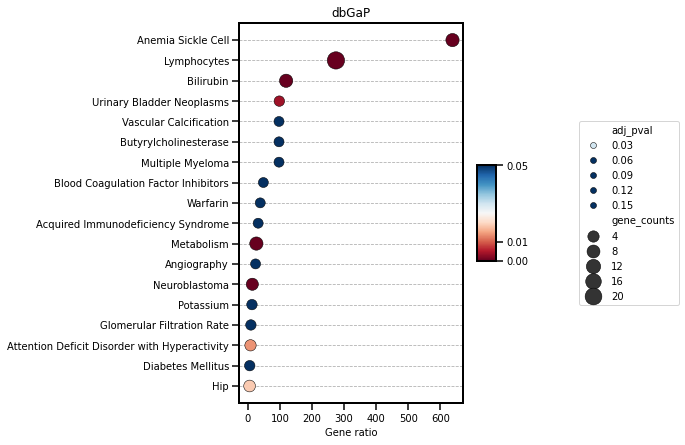

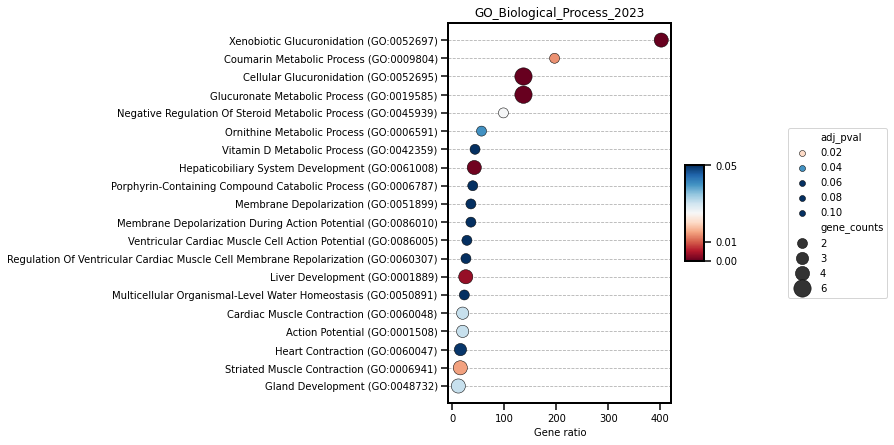

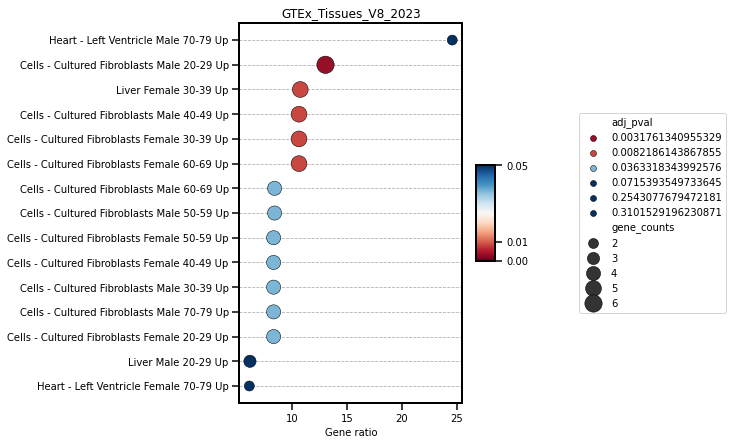

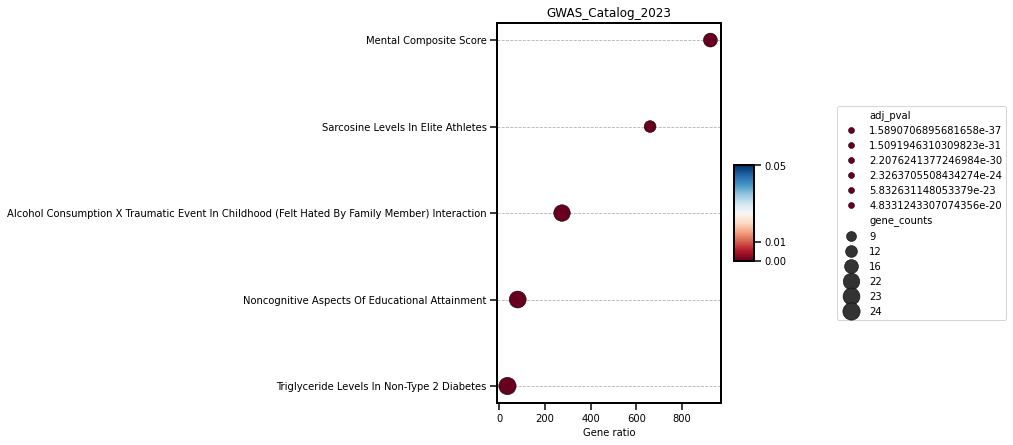

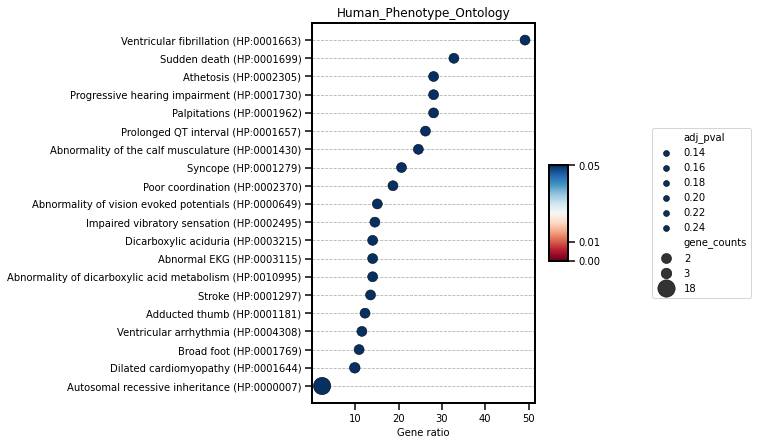

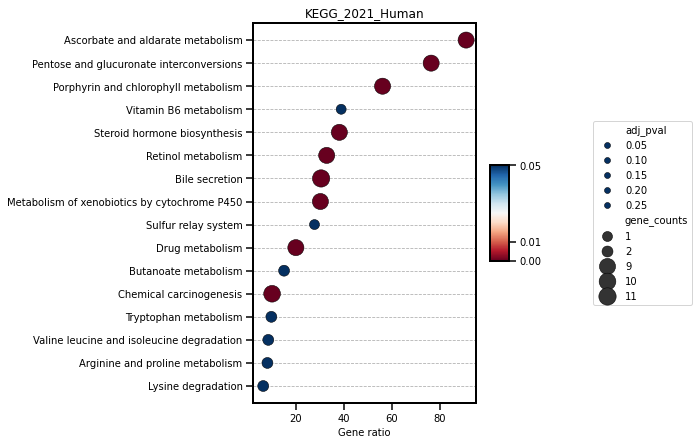

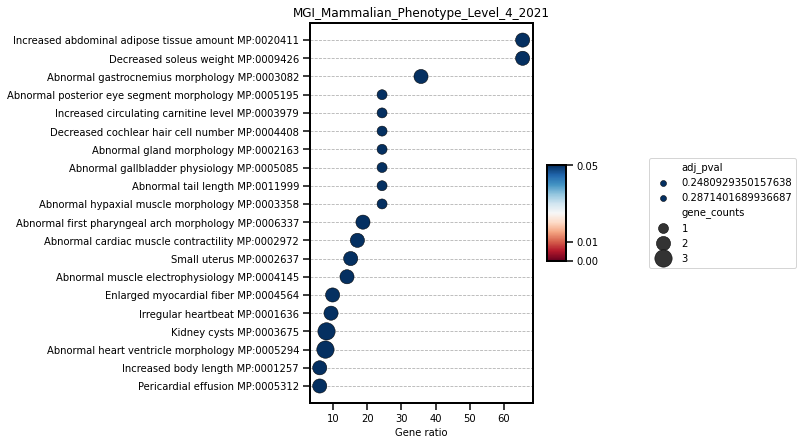

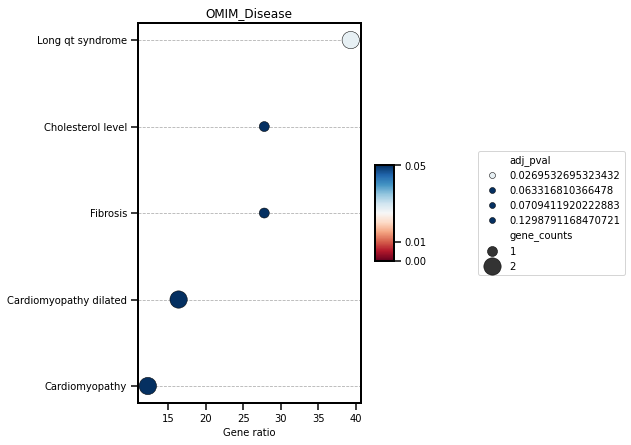

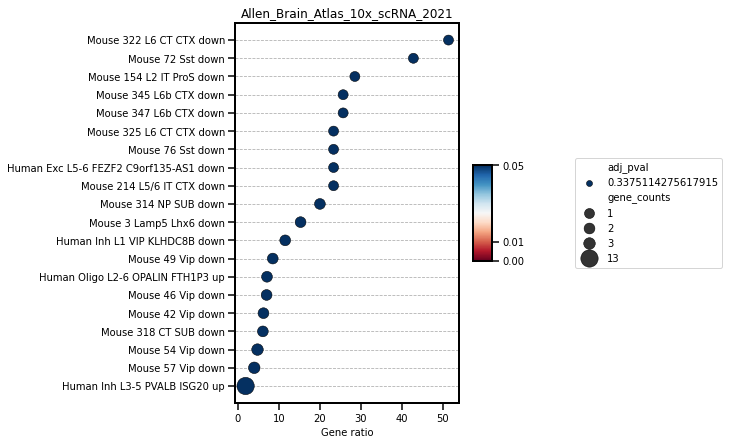

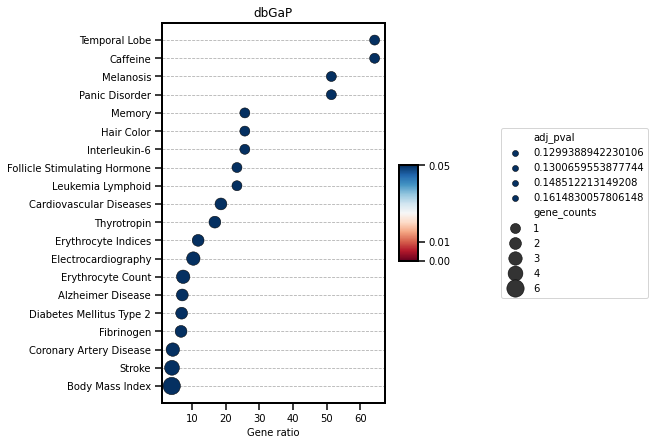

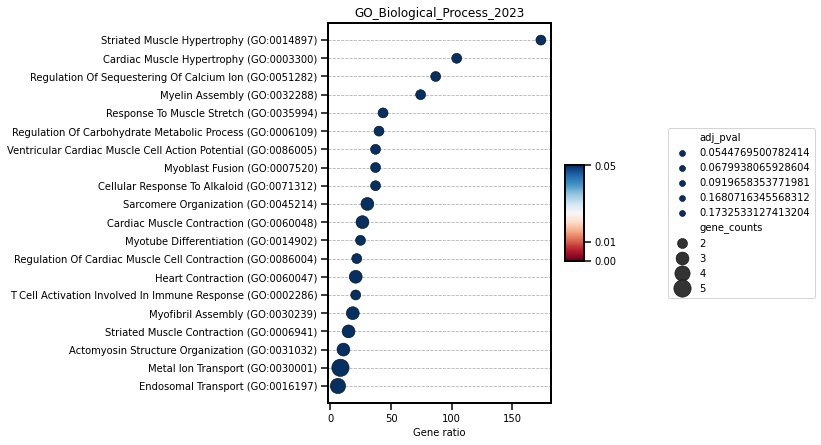

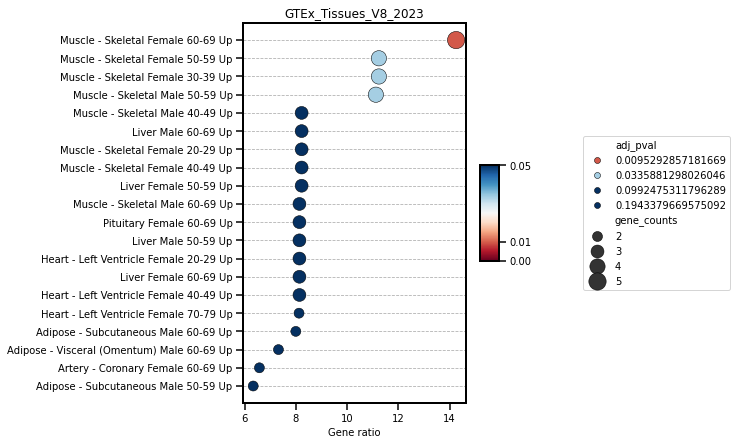

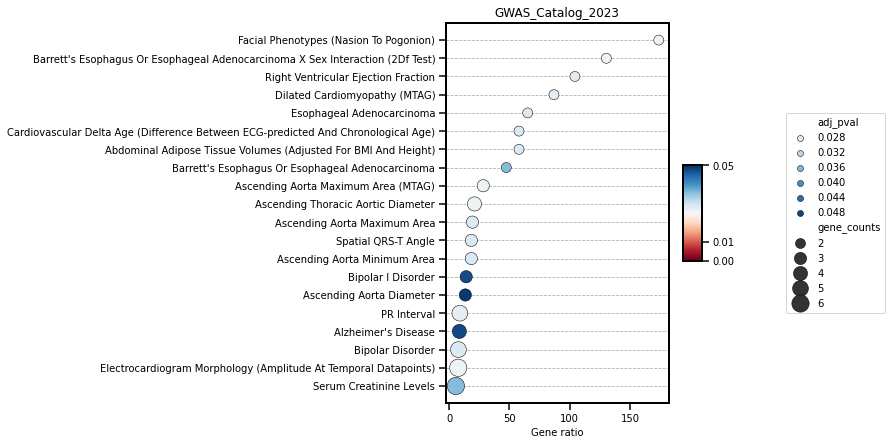

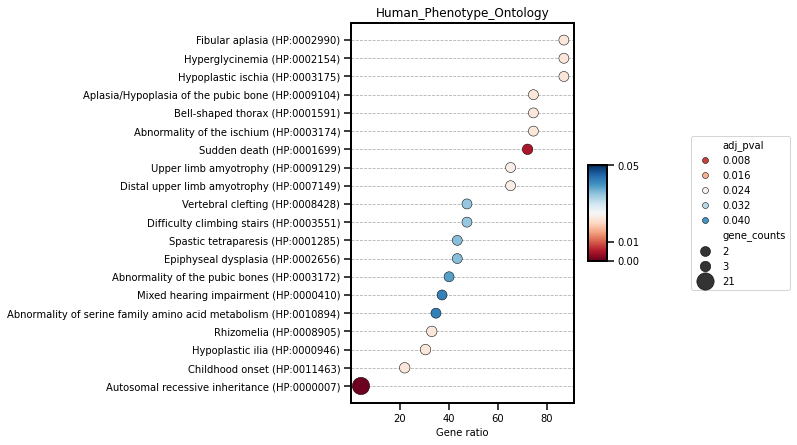

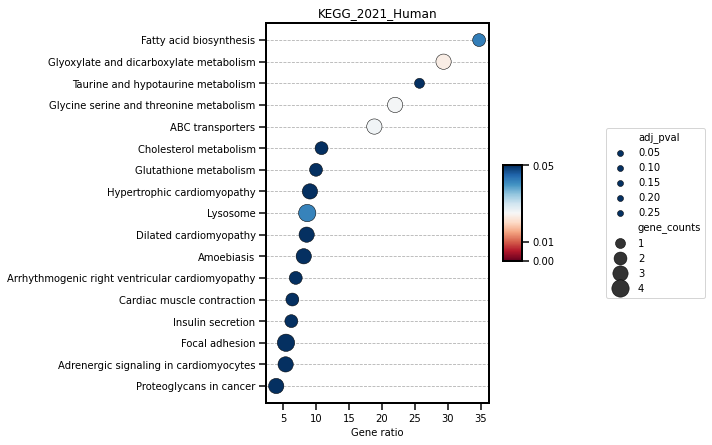

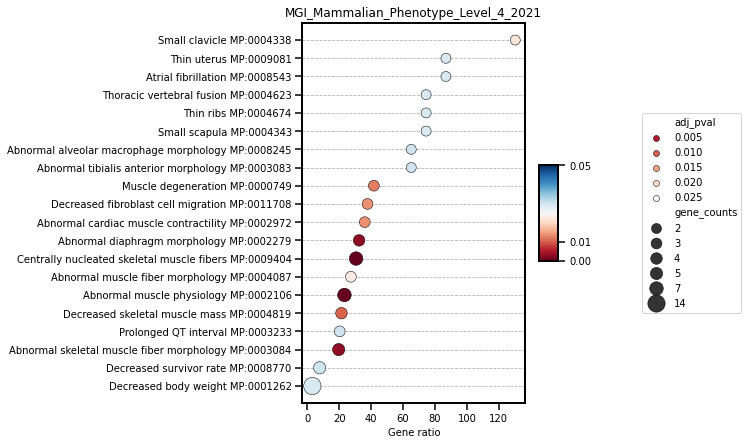

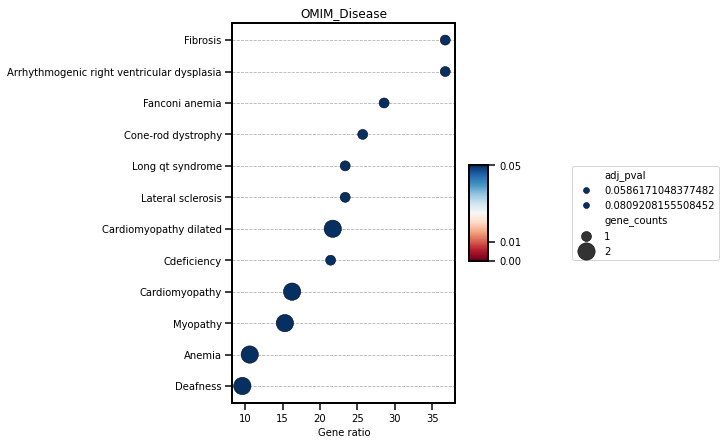

In [3]:
gene_burden_df = pd.read_csv(gene_burden_file)

for cf,sv in zip(combo_files, save_dir):
    os.makedirs(sv, exist_ok=True)
    cdf = pd.read_csv(cf)
    study_genes = get_combo_genes(cdf, sv)
    population_genes = get_population_geneset(gene_burden_df, sv)
    run_enrichment(study_genes, population_genes, sv)